# Agglomerating pizzas according to their taste

## RafaCastle

## Main objective of the analysis 

This analysis will be focused on clustering and dimensionality reduction, we are going to work with a data set that contains atributes of different kinds of pizzas, first we are going to reduce the dimensionality of the data set, then we are going to try to predict which are the attributes that make a pizza tasty clustering the dimension-reducted data. 

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from collections import Counter

from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mlxtend.plotting  import plot_decision_regions
import scipy.cluster.hierarchy as shc 
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import KernelPCA

### Description of the data set

The data set contains measurements that capture the kind of things that make a pizza tasty. The variables in the data set are:

1. Score: Pizza score (A, B, C, ... , J)
2. ID: Pizza ID (unique numeric value)
3. Mois: Amount of water per 100 grams in the sample
4. Prot: Amount of protein per 100 grams in the sample
5. Fat: Amount of fat per 100 grams in the sample
6. Ash:  Amount of ash per 100 grams in the sample
7. Sodium: Amount of sodium per 100 grams in the sample
8. Carb:  Amount of carbohydrates per 100 grams in the sample
9. Cal:  Amount of calories per 100 grams in the sample

In [2]:
df = pd.read_csv("pizza.csv")
df.head()

,score,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,A,14016,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,A,14005,30.49,21.28,41.65,4.82,1.64,1.76,4.67


## Actions taken for data cleaning or feature engineering

There are no null-values in the data set, so we're just going to transform the values of the score column to numerical as follows:

1. A
2. B
3. C
4. D
5. E
6. F
7. G
8. H
9. I
10. J

In [3]:
lab=LabelEncoder()
df["score"] = df["score"].astype("category")
lab.fit(df["score"].drop_duplicates())
df["score"] = lab.transform(df["score"])
df["score"]=-df["score"]+10
df["score"].astype("int64")
df.head()

,score,id,mois,prot,fat,ash,sodium,carb,cal
0,10,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,10,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,10,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,10,14016,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,10,14005,30.49,21.28,41.65,4.82,1.64,1.76,4.67


Now we are going to  normalize the data

In [4]:
data = normalize(df.drop(columns=["id","score"]))
data = pd.DataFrame(data, columns=df.drop(columns=["id","score"]).columns)
data.head(3)

,mois,prot,fat,ash,sodium,carb,cal
0,0.484236,0.373011,0.781009,0.088945,0.030809,0.013403,0.085812
1,0.500041,0.373144,0.770334,0.093725,0.031417,0.017902,0.084949
2,0.489613,0.345234,0.790635,0.087733,0.028151,0.013816,0.085488


## Data Exploration

### Detecting outliers

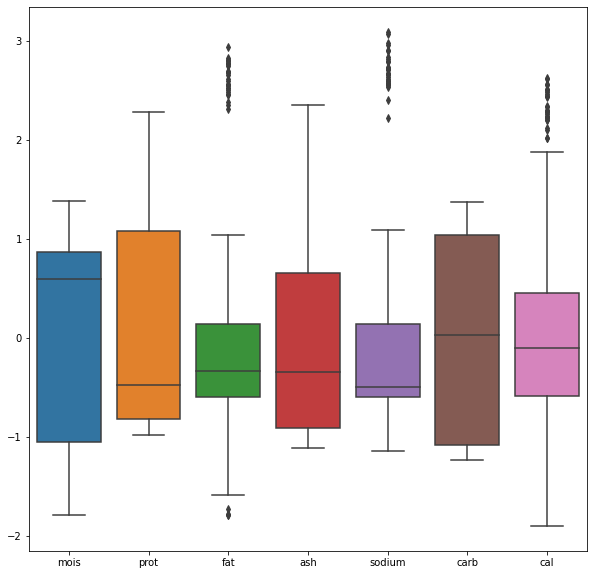

In [5]:
# Standarizing data
data_s=(data-data.mean())/data.std()

plt.figure(figsize=(10,10))
sns.boxplot(data=data_s);

When observing the variables within boxplots, it is observed that only carbohydrates and calories could have a normal distribution, in the columns of fat, sodium and calories a large number of outliers are observed, let's graph one of the variables to see its distribution, for that we are going to define a function that can save all the anomalies in the data:

In [6]:
def anomalies(data):
    anomalies=[]
    data_std=np.std(data)
    data_mean=np.mean(data)
    anomaly_treshold=data_std*1.5
    limit_left=data_mean-anomaly_treshold
    limit_right=data_mean+anomaly_treshold
    
    for datum in data:
        if datum < limit_left or datum > limit_right:
            anomalies.append(datum)
    return anomalies

Below you can better appreciate the detection of anomalies in each of the variables detected.

### Fat

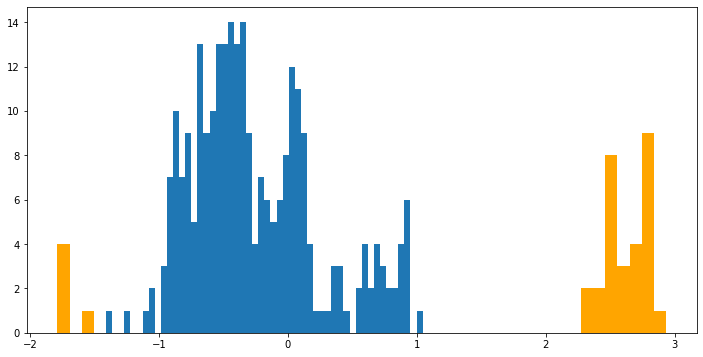

In [7]:
plt.figure(figsize=(12,6))
plt.hist(data_s["fat"],bins=100)
plt.hist(anomalies(data_s["fat"]),bins=50,color="orange");

As expected, an increment in the fat variable, leads to an increment in the calories in the pizza.

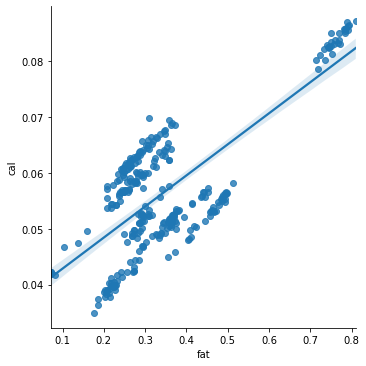

In [8]:
sns.lmplot(x="fat",y="cal", data=data);

Now let's see how do the variables affect the score value:

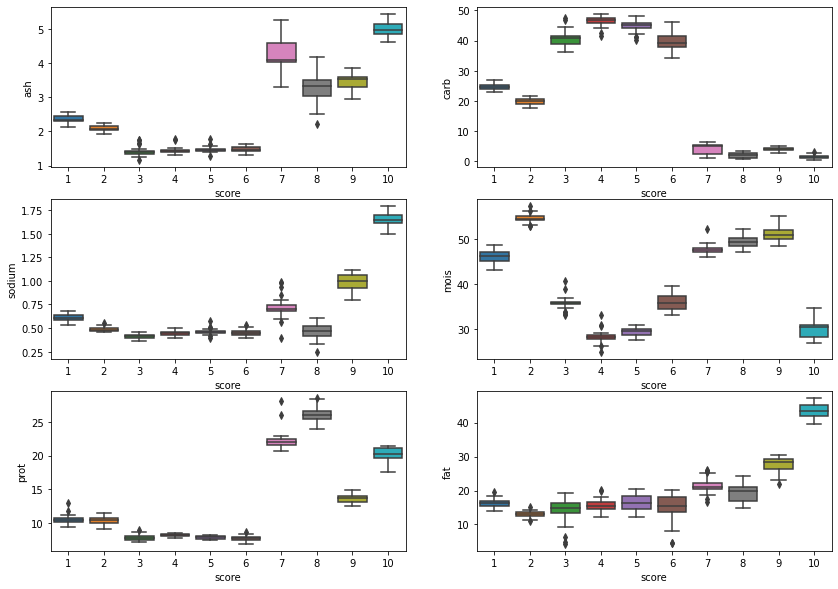

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

sns.boxplot(ax=axes[0, 0], data=df, x='score', y='ash');
sns.boxplot(ax=axes[0, 1], data=df, x='score', y='carb');
sns.boxplot(ax=axes[1, 0], data=df, x='score', y='sodium');
sns.boxplot(ax=axes[1, 1], data=df, x='score', y='mois');
sns.boxplot(ax=axes[2, 0], data=df, x='score', y='prot');
sns.boxplot(ax=axes[2, 1], data=df, x='score', y='fat');

There are some remarkable relatioships, for example the score increases with the sodium or fat, the other variables don't show such a direct relation. It is curious that the amount of calories is extremely important for the highest score, and it has a lower variance for the scores as they increase.

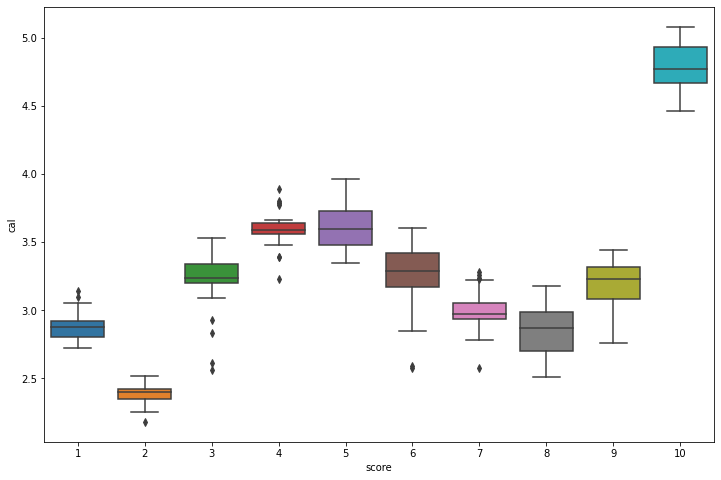

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='score', y='cal');

## Summary of data exploration

In the exploration, relationships were found between the variables and the pizza score, and it was seen that there is a direct relationship between fat, sodium and the number of calories with the score, for the other variables the relationship with the score can be somewhat more complex. A function was also obtained to highlight the outliers and the consistency between the calories and the fat of the pizzas was corroborated.

## Agglomerative clustering and DBSCAN

Let's see how does the dendogram of the data looks like:

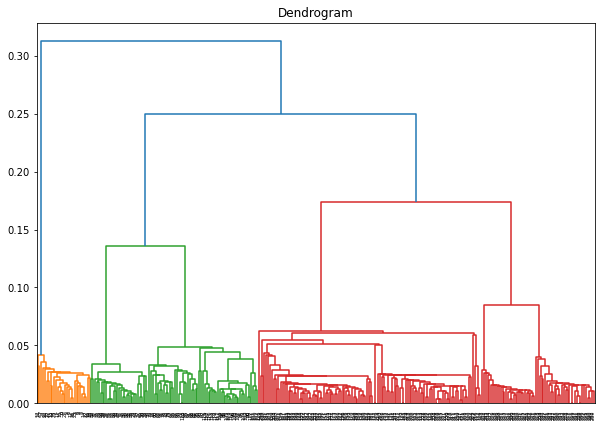

In [11]:
plt.figure(figsize=(10,7))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(data))

In this case we identify 3 groups, a number that we will use as a reference to create clusters below.

In [12]:
#Agglomerative clustering
cluster=AgglomerativeClustering(n_clusters=3,affinity="euclidean", linkage="ward")
cluster.fit_predict(data)

#DBSCAN
dbs = DBSCAN(eps=0.2,min_samples=20).fit(data)
outliers = pd.DataFrame(df.drop(columns=["id","score"]))

Let's plot 2 of the columns of the dataset (calories and carbohydrates) in order to see how do the algorithms grouped the data:

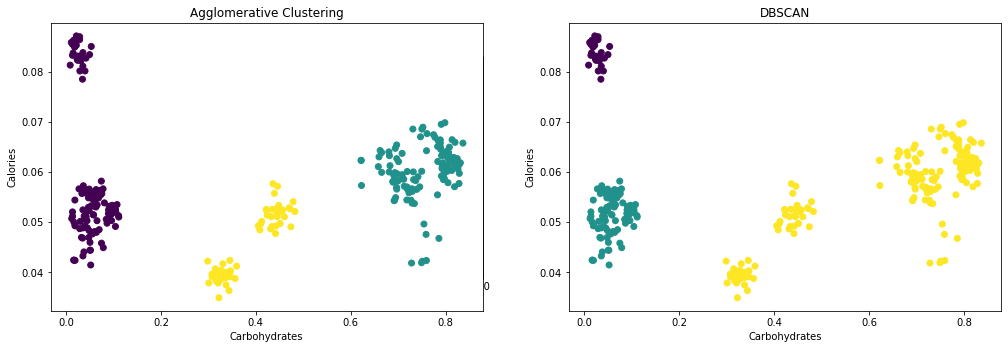

In [13]:
f, (ax1, ax2) = plt.subplots(1,2)

#Agglomerative clustering
ax1 = f.add_axes([-0.1,0,1,1])
ax1.scatter(data.iloc[:,5],data.iloc[:,6],c=cluster.labels_)
ax1.set_xlabel('Carbohydrates')
ax1.set_ylabel('Calories')
ax1.set_title('Agglomerative Clustering')

#DBSCAN
ax2 = f.add_axes([1.1,0,1,1])
colors = dbs.labels_
ax2.scatter(data.iloc[:,5].values,data.iloc[:,6].values,c=colors)
ax2.set_xlabel('Carbohydrates')
ax2.set_ylabel('Calories')
ax2.set_title('DBSCAN');

We can also add one variable (fat) to se the distribution in 3D:

<ipython-input-14-98fadd9eb213>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-14-98fadd9eb213>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


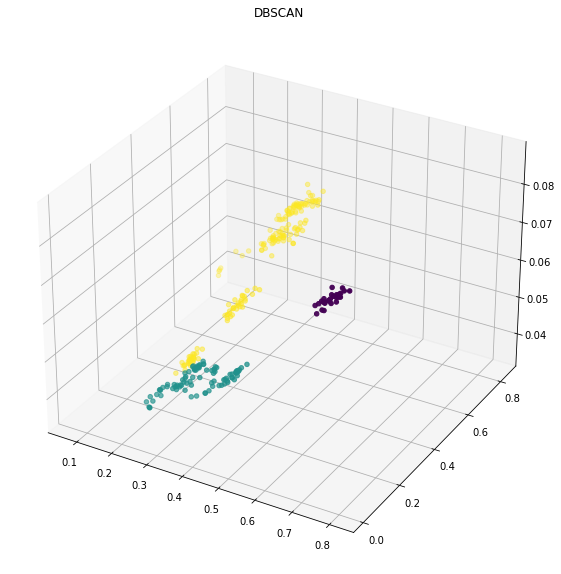

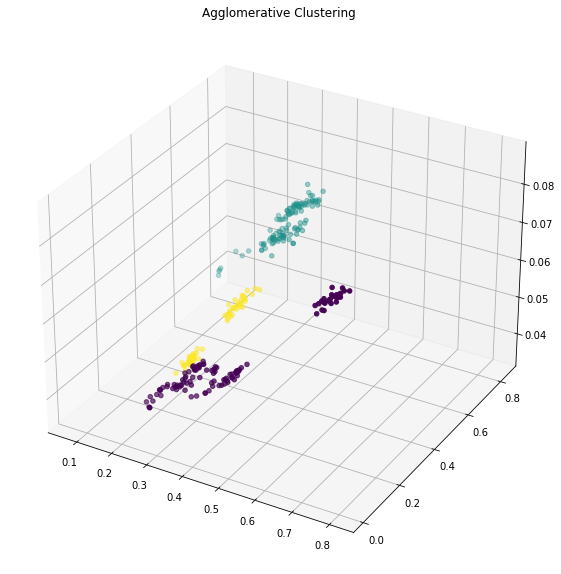

In [14]:
#DBSCAN
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(data.iloc[:,2],data.iloc[:,5],data.iloc[:,6],c=colors)
plt.title( "DBSCAN" )
fig.show()

#Agglomerative clustering
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(data.iloc[:,2],data.iloc[:,5],data.iloc[:,6],c=cluster.labels_)
plt.title( 'Agglomerative Clustering' )
fig.show()

By looking a the graphs we can see that agglomerative clustering and DBSCAN differ in the way ther grouped the data, before reaching a conclusion, let's compare them with the PCA method.

## PCA and kernel PCA

### PCA

Let's tie the pizza ratings together so that we are left with only four categories:

1. 1,2 : Very bad pizzas
2. 3,4,5,6 : Bad pizzas
3. 7,8,9 : Acceptable pizzas
4. 10 : Excelent pizzas

In [15]:
cal=[]
for i in df.score:
    if i in [1,2]:
        cal.append(1)
    elif i in [3,4,5,6]:
        cal.append(2)
    elif i in [7,8,9]:
        cal.append(3)
    elif i in [10]:
        cal.append(4)
df["newscore"]=cal

This way we're goint to have 4 clusters, now let's split the data:

In [16]:
#spliting data
X, y = df.iloc[:,2:-1].values, df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#preprocessing the data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Applying PCA for reducting dimesionality to 2D and classifing with random forest

In [17]:
#PCA 2D
pca = PCA(n_components= 2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#Random forest
rf=RandomForestClassifier()
rf.fit(X_train_pca, y_train)

RandomForestClassifier()

Plotting the decision regions 

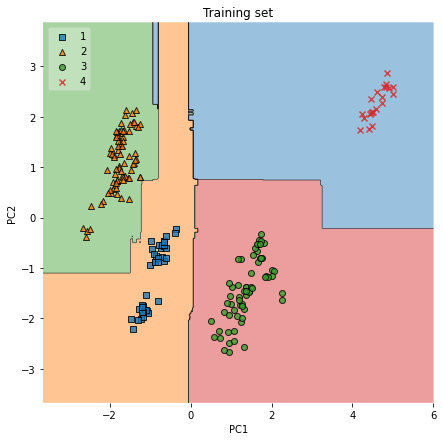

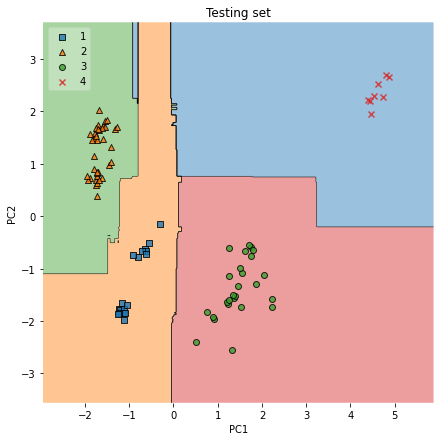

In [18]:
plt.figure(figsize=(7,7))
plot_decision_regions(X_train_pca, y_train, clf = rf, legend = 2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Training set")
plt.show()

plt.figure(figsize=(7,7))
plot_decision_regions(X_test_pca, y_test, clf = rf, legend = 2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Testing set")
plt.show()

We can see that by reducing dimensionality, we can accuarate predict the score of the pizzas with the random forest algorithm (if we group the s in 4 different categories, if we try to obtain the desicion region for the 10 different scores it gets more complicated). 

### Kernel PCA

Now let's repeat the process with the kernel PCA method.

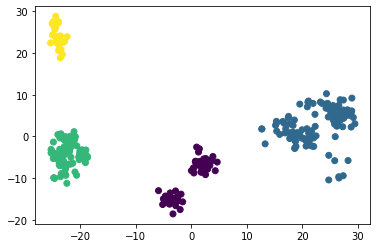

In [19]:
kpca = KernelPCA(n_components=2,gamma=5)
X_kpca = kpca.fit_transform(X)
df_kpca=pd.DataFrame(X_kpca)

plt.scatter(df_kpca.iloc[:,0],df_kpca.iloc[:,1],c=y);

Curiously, the results look very simiar to the obtained with the agglomerative clusteing method (with a different scale), now let's see how does the plot look like for 3 components:

<ipython-input-20-40cc73d07743>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


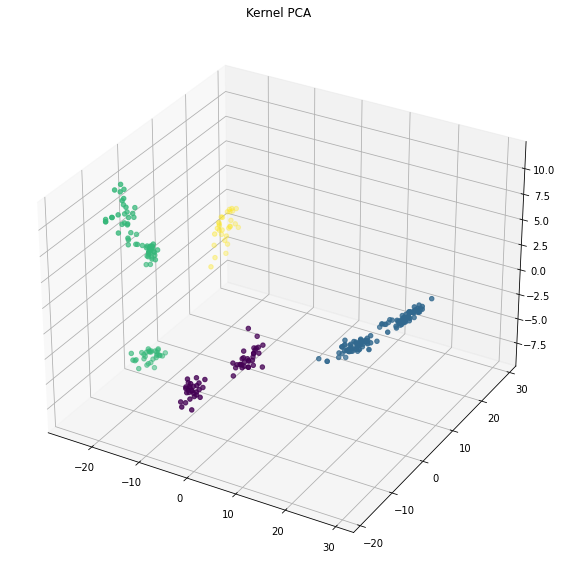

In [20]:
kpca = KernelPCA(n_components=3)
X_kpca = kpca.fit_transform(X)
df_kpca=pd.DataFrame(X_kpca)

#plot
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
ax.scatter3D(df_kpca.iloc[:,0],df_kpca.iloc[:,1],df_kpca.iloc[:,2],c=y)
plt.title( 'Kernel PCA' )
fig.show()

## Summary of unsupervised models

We obtained different results with the clustering models and with the dimensionality reduction models, however, the kernel PCA and the PCA models shows us some similar behaviors. If we take a closer look to the 2D graphs, we can appreciate similar forms in the way the models grouped the data, if we rotate the kernel PCA graph 90 degrees, we can almost reproduce the PCA graph (rescaling). This fact shows us how consistent the reduction models are.

## Best model

The kernel PCA model worked faster and gave more separate data, it could also be used with random forest or some other classification algorithm in order to predict the pizza score.

## Summary Key Findings and Insights

In general, when working with the data, a good grouping was shown for the extreme values of the score (9,10) for both the test and training sets, with a marked error for the intermediate categories. This may reflect how difficult it is for a person to categorize the taste of pizzas that are not entirely tasty, but do not taste bad either. Therefore, it is concluded that the rating of the pizza can be satisfactorily predicted for high ratings (pizzas with an excellent flavor) or very low (pizzas that taste bad) in a numerical way by the mentioned parameters. Because of this, the score values of the pizzas were divided into fewer categories (4) to make it easier to categorize it subjectively. The results were satisfactory even when the dimensionality of the dataset is reduced.

## Suggestions for next steps in analyzing this data

It would be interesting to add more parameters to the data set, such as toppings or pizza price to obtain more specific results.